Sergi Muyo Abad         

Student number: 222738

# Introduction

In this project I will analyse a set of pH measurements. This measurements were taken in an experiment over the course of 3 days.

The main aim of the project is to check whether the measurements vary between the different sampling tiems or are instead what we would expect from a stable culture.

To do this I created a bayesian model thet can simulate more measurements, and calculate the expected real pH values of the sample by removing all the noise.

# Code

First I import all the packages I will need.

In [2]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import arviz as az
from stanio.json import process_dictionary

Now I input some data for the simulations. This data comprises of:

- num_samples: The number of pH measurments I have


- measurements: The measured pH values

- neutral: Neutral pH. We would expect the samples to have a pH similar to this

- num_calibration: The number of calibration samples I have

- cali_meas: The measured pH of the calibration samples

- cali_real: The true pH of the calibration samples


In [3]:
num_samples = 52
measurements = [
    6.55, 6.55, 6.96, 7.01, 
    6.92, 6.92, 6.94, 7.00, 
    6.91, 7.05, 6.98, 7, 
    6.91, 6.97, 6.92, 6.96, 
    7.00, 6.94, 6.88, 6.91, 
    6.89, 6.88, 6.92, 6.92, 
    6.92, 6.91, 6.90, 6.99, 
    6.96, 7.01, 6.9, 6.95, 
    6.89, 6.9, 6.89, 6.95, 
    6.88, 6.90, 6.93, 6.96, 
    6.94, 6.93, 6.94, 6.88, 
    6.88, 6.9, 6.86, 6.91, 
    6.88, 6.99, 6.92, 6.88
    ]
neutral = 7.0
num_calibration = 3
cali_meas = [3.98, 7.01, 9.01]
cali_real = [4.00, 7.00, 9.00]

# Model

Now I load the model and input the prior data.

In [4]:
model = CmdStanModel(stan_file="pH_v2.stan")

prior_data = process_dictionary({
        "N": num_samples,
        "measurements" : measurements,
        "ave": neutral,
        "N_calibration_measurement": num_calibration,
        "calibration_measurements": cali_meas,
        "calibration_ph": cali_real
    }
)

My model produces the measurement values with the following model:

    measurement ~ N(pH + bias, curr_err + biological_noise)

The parameters of the linear model are:

- measurement: The measured pH value.

- pH: The real pH value. For the samples it is assumed to be 7.0 (see variable "neutral")

- bias. the calibration error. This calibration error is calculated using the calibration measurements, assuming that those measurements come from a normal distribution centered at the true pH of the calibration media, with a standard deviation equal to the calibration noise.

- curr_err: The pH meter accuracy. This is calculated from a normal distribution centered at 0.01 and with a standard deviation of 0.1

- biological_noise: This parameter accounts for biological noise. It is calculated from a lognormal distribution centered at 0.05, with a standard deviation of 0.1.

In [5]:
print(model.code())

functions {
  vector standardise(vector v, real m, real s) {
    return (v - m) / s;
  }
  real standardise(real v, real m, real s) {
    return (v - m) / s;
  }
  vector unstandardise(vector u, real m, real s) {
    return m + u * s;
  }
  real unstandardise(real u, real m, real s) {
    return m + u * s;
  }
}

data {
    int<lower=1> N;
    int<lower=1> N_calibration_measurement;
    vector[N] measurements;
    vector[N_calibration_measurement] calibration_measurements;
    vector[N_calibration_measurement] calibration_ph;
    real ave;
}

transformed data {
    vector[N] meas_ls = standardise(log(measurements), mean(log(measurements)), sd(log(measurements)));
    real ave_ls = standardise(log(ave), mean(log(measurements)), sd(log(measurements)));
}

parameters {
    real true_ph_ls;
    real<lower=0> biological_noise;
    real bias;
    real curr_err;
}

model {
    curr_err ~ lognormal(log(0.01), 0.1);
    biological_noise ~ lognormal(log(0.05), 0.1);
    meas_ls ~ normal(true_ph_

In [6]:
mcmc_res = model.sample(data=prior_data)

15:44:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                     

15:44:13 - cmdstanpy - INFO - CmdStan done processing.
15:44:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -218.005, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -217.118, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -52.8586, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -12.5066, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -2.37701, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -12246, but must be nonnegative! (in 'pH_v2.stan', line 38, column 4 to column 41)
	Exception: lognormal_lpdf: Random variable is -235.882, but must be nonnegative! (in 'pH_

In [7]:
print(mcmc_res.summary())
print(mcmc_res.diagnose())

                        Mean      MCSE    StdDev          5%         50%  \
lp__             -308.712000  0.037273  1.459580 -311.477000 -308.365000   
true_ph_ls          0.000974  0.001199  0.061391   -0.099643    0.001999   
biological_noise    0.424791  0.000326  0.016986    0.397680    0.424178   
bias               -0.000149  0.000119  0.006483   -0.011099   -0.000371   
curr_err            0.010974  0.000016  0.001095    0.009265    0.010931   
true_ph             6.915710  0.000104  0.005335    6.906970    6.915800   
yrep                6.916680  0.000600  0.037635    6.855270    6.916930   

                         95%    N_Eff   N_Eff/s     R_hat  
lp__             -307.051000  1533.47   7302.26  1.002350  
true_ph_ls          0.104362  2620.21  12477.20  0.999730  
biological_noise    0.453722  2711.89  12913.80  1.000610  
bias                0.010325  2947.69  14036.60  1.001250  
curr_err            0.012834  4477.12  21319.60  0.999847  
true_ph             6.924700  2

The disgnostics for the model look good. The R_hat is what we would expect, and we did not have nay divergent transitions.

Now I will load the data and format it for plotting.

In [8]:
idata = az.from_cmdstanpy(mcmc_res)

idata.to_json("my_arviz_idata.json")

true_vals = idata.posterior.true_ph.values.flatten()
sim_vals = idata.posterior.yrep.values.flatten()

# Plots

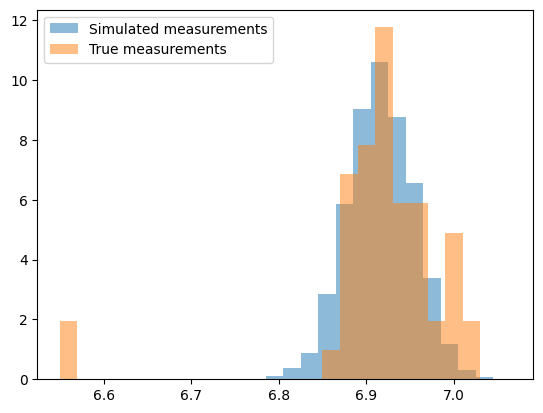

In [9]:
w = 0.02

plt.hist(sim_vals, label="Simulated measurements", density=True, bins=np.arange(min(sim_vals), max(sim_vals) + w, w), alpha=0.5)
plt.hist(measurements, label="True measurements", density=True, bins=np.arange(min(measurements), max(measurements) + w, w), alpha=0.5)

plt.legend()

In this previous plot we see the simulated measurements and the measurements we took in the experiment.

Both sets of measurements look quite similar. There are 2 samples from our true measurements that are lower than we would expect, and we can see a small bump in density around pH 7.0 that we do not see in the simulated measurements, but overall we can conclude that the true measurements do not deviate from the expected data.

Finally, I will plot the true pH values predicted by the model.

<Axes: title={'center': 'true_ph'}>

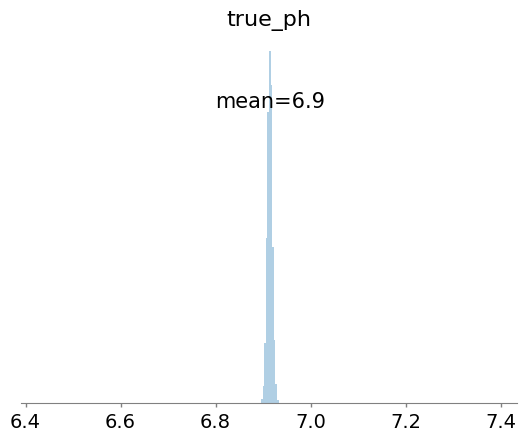

In [10]:
az.plot_posterior(idata.posterior.true_ph, kind="hist", hdi_prob="hide")

Our model indicates that the true values of our measurements are all very similar, with a constant pH at 6.9.